# Challenge - Human Resource Analytics

Engineer your features, then create three models. Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach). The models should be:

1. Vanilla logistic regression
2. Ridge logistic regression
3. Lasso logistic regression

In your report, evaluate all three models and decide on your best. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?

### Data Desciption

Decided on using a dataset from Kaggle to predict whether an employee will stay or leave.

In [130]:
#Imports

#Basic Imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math

#Plotting
import seaborn as sns
%matplotlib inline
sns.set_style('white')

#Models
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm


#Data Infrastructure Pieces
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.model_selection import cross_val_score

In [4]:
#Import the data
df = pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### EDA

In [5]:
#Check to see if there are Null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [116]:
#There is a class imbalance
df['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

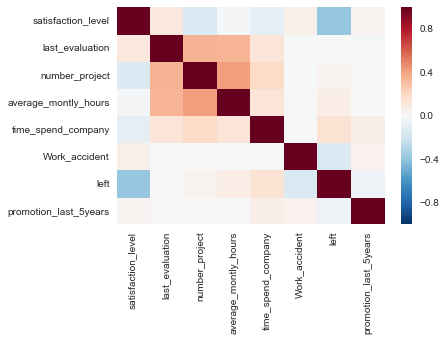

In [6]:
sns.heatmap(df.corr())

In [7]:
df['sales'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

### Feature Engineering

In [8]:
#Create Dummy variables fort he sales column
cat_feats = ['sales']
data = pd.get_dummies(df, columns=cat_feats, drop_first=True)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,1,0,0


In [9]:
#Turn Salary into values:
salary_values = {'low':30000, 'medium':50000, 'high':100000}
data.replace({'salary':salary_values}, inplace=True)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,0,1,0,30000,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,50000,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,50000,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,30000,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,30000,0,0,0,0,0,0,1,0,0


In [41]:
#Do the Train, Test split
X = data.drop('left', axis=1)
y = data['left']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

### Vanilla Logistic Regression

Since the sklearn logistic regression will either use ridge or lasso, will have to use the stats model logistic regression.

In [13]:
# Declare predictors.
X_statsmod = X_train.copy()

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X_statsmod['intercept'] = 1 

# Declare and fit the model.
logit = sm.Logit(y_train, X_statsmod)
result = logit.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.428071
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   left   No. Observations:                10499
Model:                          Logit   Df Residuals:                    10481
Method:                           MLE   Df Model:                           17
Date:                Thu, 08 Mar 2018   Pseudo R-squ.:                  0.2211
Time:                        14:50:30   Log-Likelihood:                -4494.3
converged:                       True   LL-Null:                       -5769.9
                                        LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
satisfaction_level       -4.1424      0.117    -35.322      0.000      -4.372      -3.

In [14]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_statsmod)

# Code admission as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(y_train, pred_y_statsmod)

print('\n Accuracy by admission status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


 Accuracy by admission status
col_0     0    1
left            
0      7421  572
1      1608  898

 Percentage accuracy
0.792361177255


### Ridge Logistic Regression

In [119]:
ridgemodel = LogisticRegression(C=0.01, penalty='l2')
ridgemodel.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [120]:
ridgemodel.score(X_test, y_test)

0.74955555555555553

In [118]:
#Get Metrics
pred_y_sklearn = ridgemodel.predict(X_test)

#Print Confusion matrix. Notice didnt predict anyone would leave. 
print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_test))

#Print R Score
print('\n Percentage accuracy')
print(ridgemodel.score(X_test, y_test))


 Accuracy by admission status
left      0     1
row_0            
0      3373  1127

 Percentage accuracy
0.749555555556


In [121]:
#Do a cross validation 
print(cross_val_score(ridgemodel, X_test, y_test, cv=5))

[ 0.74916759  0.74916759  0.75        0.74972191  0.74972191]


#### Grid Search

In [126]:
# Instantiate and fit our model.
lr = LogisticRegression()

parameters = {'penalty':['l2'],
             'C':[0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

#Note for regression problems have to do different scoreing methods:
grid = GridSearchCV(lr, parameters, cv=5, verbose=0)


#Fit the Data
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000, 100000, 100000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [113]:
grid.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [114]:
grid.best_score_

0.76721592532622152

In [127]:
#Metrics
pred_y_sklearn = grid.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_test))

print('\n Percentage accuracy')
print(grid.score(X_test, y_test))


 Accuracy by admission status
left      0     1
row_0            
0      3373  1127

 Percentage accuracy
0.749555555556


In [135]:
#Print Classification Report
print(classification_report(y_test, pred_y_sklearn))

             precision    recall  f1-score   support

          0       0.75      1.00      0.86      3373
          1       0.00      0.00      0.00      1127

avg / total       0.56      0.75      0.64      4500



/Users/brandyn/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Lasso Regression

In [136]:
#Difference is the penalty. The Lasso will be L1
# Instantiate and fit our model.
lr = LogisticRegression()

parameters = {'penalty':['l1'],
             'C':[0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

#Note for regression problems have to do different scoreing methods:
grid = GridSearchCV(lr, parameters, cv=5, verbose=0)


#Fit the Data
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000, 100000, 100000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [137]:
grid.best_params_

{'C': 100000000, 'penalty': 'l1'}

In [138]:
grid.best_score_

0.79226593008857982

In [139]:
#Metrics
pred_y_sklearn = grid.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_test))

print('\n Percentage accuracy')
print(grid.score(X_test, y_test))


 Accuracy by admission status
left      0    1
row_0           
0      3147  794
1       226  333

 Percentage accuracy
0.773333333333


Notice the Lasso did predict people will leave. Need to look at other metrics.

In [140]:
#Print Classification Report
print(classification_report(y_test, pred_y_sklearn))

             precision    recall  f1-score   support

          0       0.80      0.93      0.86      3373
          1       0.60      0.30      0.40      1127

avg / total       0.75      0.77      0.74      4500



#### As we can see, since the datset is imbalanced, our models are picking up on the class that has the most members. We can try different techniques for dealing with class imbalances in order to improve our score and make the model less biased.

Will use the class_weight attributed in Logisitc regression to deal with this. Set it to balanced.




### Ridge Logistic With Undersampling

In [141]:
# Instantiate and fit our model.
lr = LogisticRegression(class_weight='balanced',penalty='l2')

parameters = {'C':[0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

#Note for regression problems have to do different scoreing methods:
grid = GridSearchCV(lr, parameters, cv=5, verbose=0)

#Fit the Data
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000, 100000, 100000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [142]:
grid.best_params_

{'C': 0.1}

In [143]:
grid.best_score_

0.76559672349747598

In [144]:
#Metrics
pred_y_sklearn = grid.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_test))

print('\n Percentage accuracy')
print(grid.score(X_test, y_test))


 Accuracy by admission status
left      0    1
row_0           
0      2568  228
1       805  899

 Percentage accuracy
0.770444444444


In [145]:
#Print Classification Report
print(classification_report(y_test, pred_y_sklearn))

             precision    recall  f1-score   support

          0       0.92      0.76      0.83      3373
          1       0.53      0.80      0.64      1127

avg / total       0.82      0.77      0.78      4500



### Lasso Regression with Undersampling

In [146]:
# Instantiate and fit our model.
lr = LogisticRegression(class_weight='balanced',penalty='l1')

parameters = {'C':[0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

#Note for regression problems have to do different scoreing methods:
grid = GridSearchCV(lr, parameters, cv=5, verbose=0)

#Fit the Data
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000, 100000, 100000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [148]:
#Metrics
pred_y_sklearn = grid.predict(X_test)

print('\n Accuracy by admission status')
print(pd.crosstab(pred_y_sklearn, y_test))

print('\n Percentage accuracy')
print(grid.score(X_test, y_test))


 Accuracy by admission status
left      0    1
row_0           
0      2571  245
1       802  882

 Percentage accuracy
0.767333333333


In [149]:
#Print Classification Report
print(classification_report(y_test, pred_y_sklearn))

             precision    recall  f1-score   support

          0       0.91      0.76      0.83      3373
          1       0.52      0.78      0.63      1127

avg / total       0.82      0.77      0.78      4500



Note the scores for predicting when people leave went up because of the undersampling.

### Write Up.


Prior to handling the undersampleing, the Lasso Regression did well in this dataset. By using grid search I was able to find the optimal C value, and then with handling the unbalanced dataset, I was able to greatly improve the precision and recall for predicting when someone will leave.